In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

np.random.seed(42)

In [2]:
df = pd.read_csv('cyberbullying_tweets.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

df.head()

Dataset shape: (47692, 2)

Columns: ['tweet_text', 'cyberbullying_type']


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [3]:
print(f"Class distribution:\n{df['cyberbullying_type'].value_counts()}")
print(f"Number of unique classes: {df['cyberbullying_type'].nunique()}")

Class distribution:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64
Number of unique classes: 6


In [ ]:
def _remove_emojis(s):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F]"
        "|[\U0001F300-\U0001F5FF]"
        "|[\U0001F680-\U0001F6FF]"
        "|[\U0001F1E0-\U0001F1FF]"
        "|[\U00002700-\U000027BF]"
        "|[\U0001F900-\U0001F9FF]"
        "|[\U00002600-\U000026FF]",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(" ", s)


def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = text.replace("#", "")
    text = _remove_emojis(text)
    text = re.sub(r"_+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

df['processed_text'] = df['tweet_text'].apply(preprocess_text)

In [ ]:
X = df['processed_text']
y = df['cyberbullying_type']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33383
Validation set size: 4770
Test set size: 9539


In [ ]:
word_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=2
)

X_train_word = word_vectorizer.fit_transform(X_train)
X_train_char = char_vectorizer.fit_transform(X_train)

X_val_word = word_vectorizer.transform(X_val)
X_val_char = char_vectorizer.transform(X_val)

X_test_word = word_vectorizer.transform(X_test)
X_test_char = char_vectorizer.transform(X_test)

X_train_tfidf = hstack([X_train_word, X_train_char])
X_val_tfidf = hstack([X_val_word, X_val_char])
X_test_tfidf = hstack([X_test_word, X_test_char])

cnb_model = ComplementNB()
cnb_model.fit(X_train_tfidf, y_train)

y_val_pred = cnb_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Results:")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Results:
Validation Accuracy: 0.7671
Validation Classification Report:
                     precision    recall  f1-score   support

                age       0.71      0.99      0.83       800
          ethnicity       0.85      0.95      0.90       796
             gender       0.85      0.84      0.84       797
  not_cyberbullying       0.72      0.37      0.49       795
other_cyberbullying       0.66      0.46      0.54       782
           religion       0.77      0.99      0.87       800

           accuracy                           0.77      4770
          macro avg       0.76      0.77      0.74      4770
       weighted avg       0.76      0.77      0.74      4770



In [ ]:
y_pred = cnb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7623
Test Classification Report:
                     precision    recall  f1-score   support

                age       0.73      0.99      0.84      1598
          ethnicity       0.85      0.93      0.88      1592
             gender       0.86      0.84      0.85      1595
  not_cyberbullying       0.66      0.37      0.47      1589
other_cyberbullying       0.64      0.45      0.53      1565
           religion       0.76      0.99      0.86      1600

           accuracy                           0.76      9539
          macro avg       0.75      0.76      0.74      9539
       weighted avg       0.75      0.76      0.74      9539



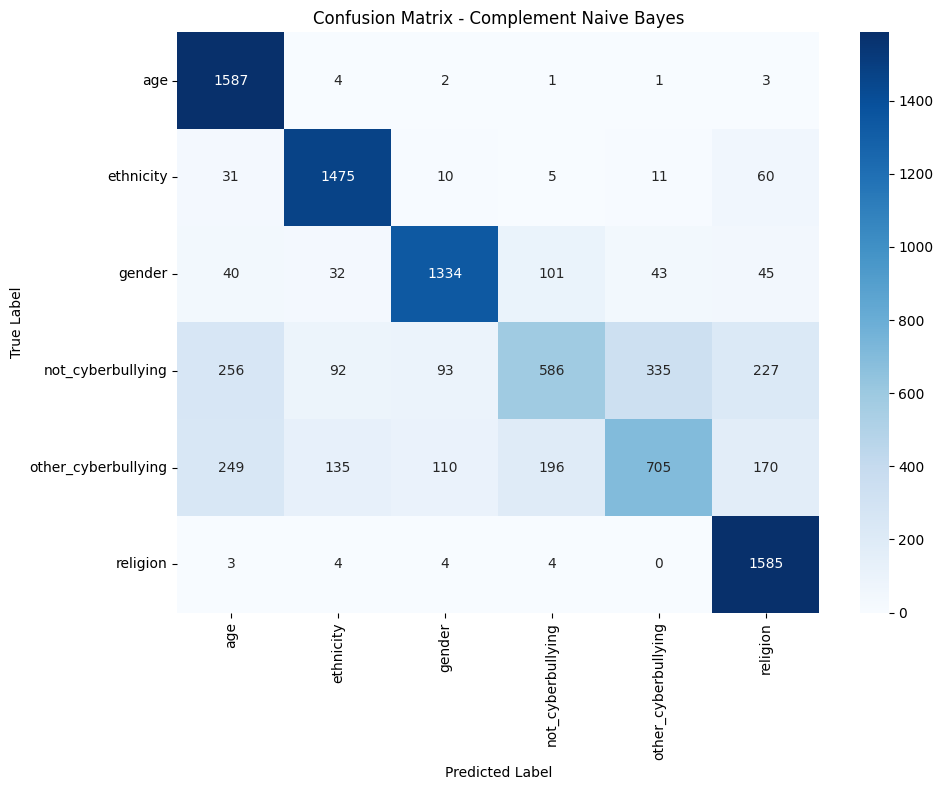

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cnb_model.classes_, 
            yticklabels=cnb_model.classes_)
plt.title('Confusion Matrix - Complement Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

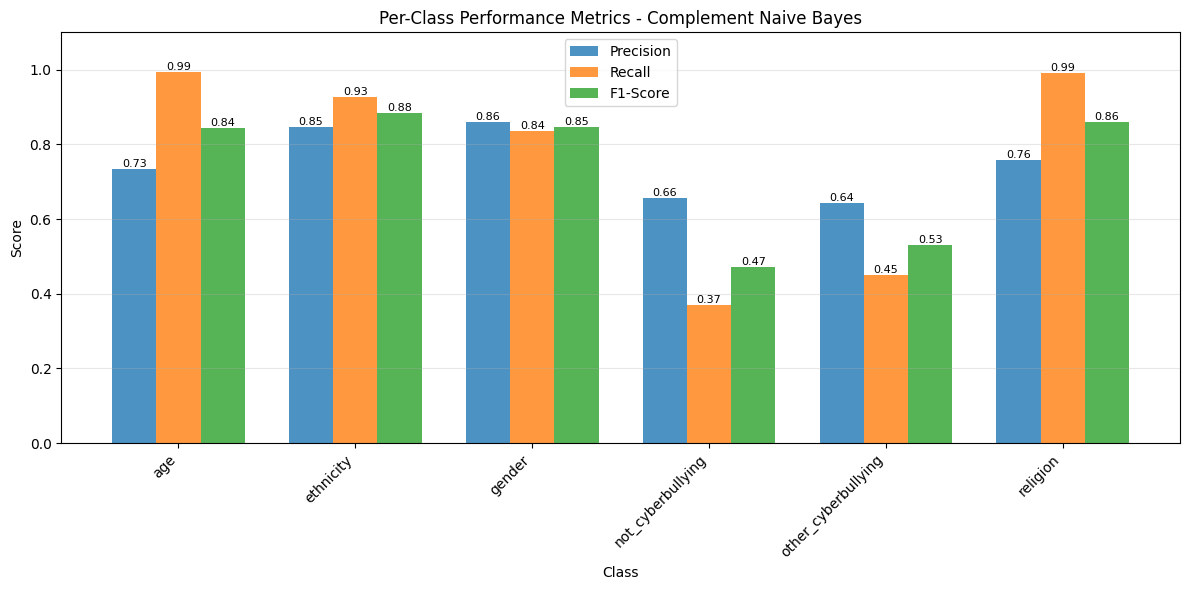

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=cnb_model.classes_)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(cnb_model.classes_))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Per-Class Performance Metrics - Complement Naive Bayes')
ax.set_xticks(x)
ax.set_xticklabels(cnb_model.classes_, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

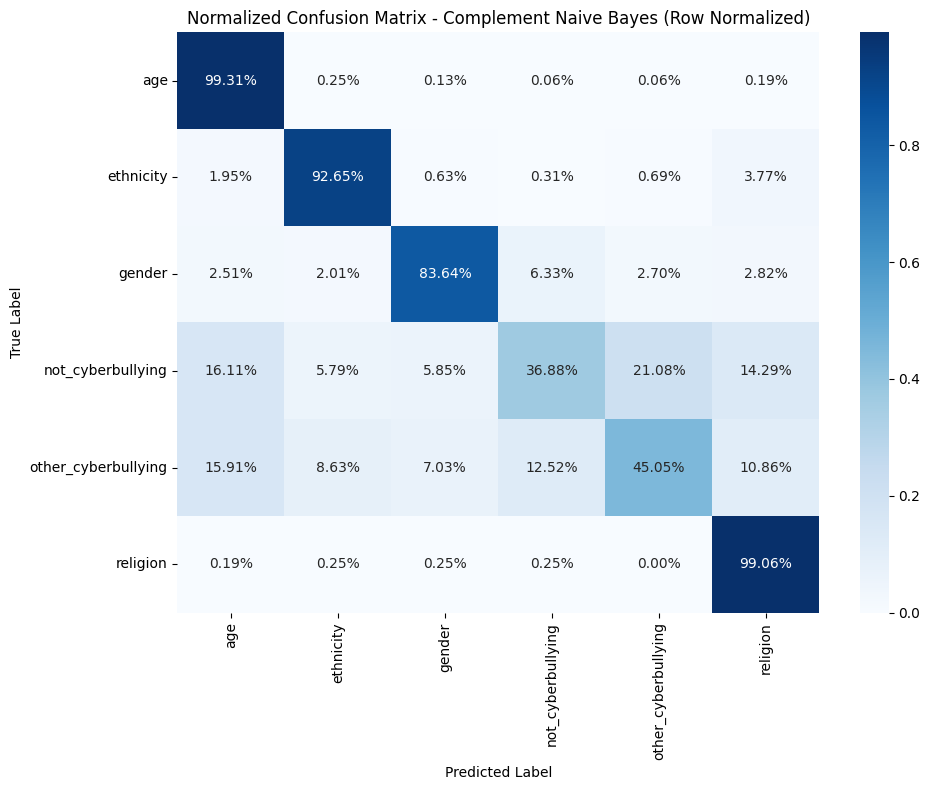

In [ ]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=cnb_model.classes_, 
            yticklabels=cnb_model.classes_)
plt.title('Normalized Confusion Matrix - Complement Naive Bayes (Row Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

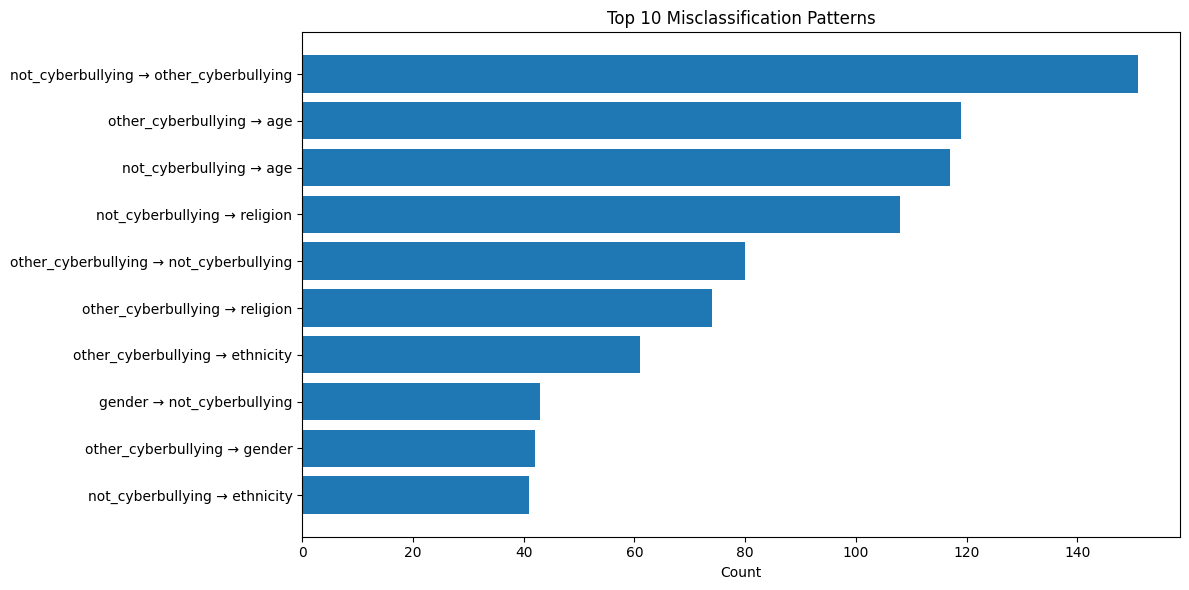


Total misclassifications: 2267
Misclassification rate: 23.77%


In [ ]:
from collections import Counter

misclassified = y_test != y_pred
misclassified_indices = np.where(misclassified)[0]

misclass_patterns = []
for idx in misclassified_indices[:1000]:
    true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    pred_label = y_pred[idx]
    misclass_patterns.append(f"{true_label} → {pred_label}")

pattern_counts = Counter(misclass_patterns).most_common(10)

if pattern_counts:
    patterns, counts = zip(*pattern_counts)
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(patterns)), counts)
    plt.yticks(range(len(patterns)), patterns)
    plt.xlabel('Count')
    plt.title('Top 10 Misclassification Patterns')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal misclassifications: {len(misclassified_indices)}")
    print(f"Misclassification rate: {len(misclassified_indices)/len(y_test):.2%}")

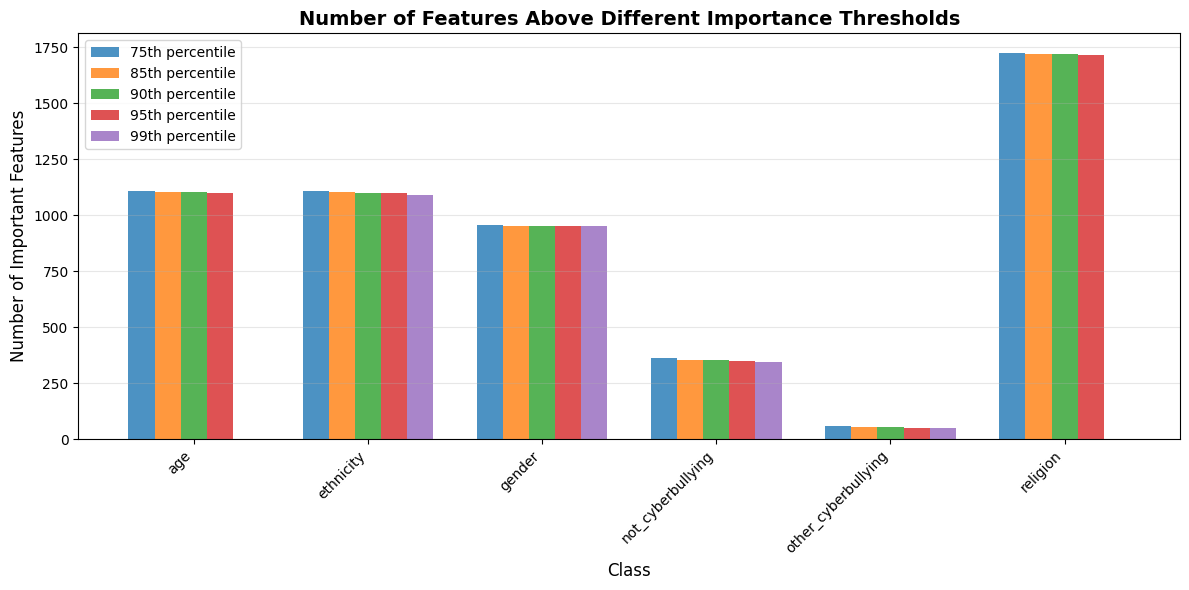

This shows how many features are 'important' for each class at different thresholds.
Classes with more important features may be more distinctive or easier to classify.


In [ ]:
thresholds = [np.percentile(log_probs.flatten(), p) for p in [75, 85, 90, 95, 99]]
threshold_labels = ['75th', '85th', '90th', '95th', '99th']

important_feature_counts = {label: [] for label in threshold_labels}

for idx, class_name in enumerate(cnb_model.classes_):
    class_log_probs = log_probs[idx][:num_word_features]
    for threshold, label in zip(thresholds, threshold_labels):
        count = np.sum(class_log_probs >= threshold)
        important_feature_counts[label].append(count)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(cnb_model.classes_))
width = 0.15

for i, (label, counts) in enumerate(important_feature_counts.items()):
    offset = (i - 2) * width
    ax.bar(x + offset, counts, width, label=f'{label} percentile', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Number of Important Features', fontsize=12)
ax.set_title('Number of Features Above Different Importance Thresholds', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cnb_model.classes_, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("This shows how many features are 'important' for each class at different thresholds.")
print("Classes with more important features may be more distinctive or easier to classify.")

In [ ]:
print("=" * 60)
print("ACCURACY COMPARISON")
print("=" * 60)
print(f"Complement Naive Bayes: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Linear SVM (from reference): 0.8193 (81.93%)")
print(f"Difference: {0.8193 - accuracy:.4f} ({abs(0.8193 - accuracy)*100:.2f} percentage points)")
print("\n" + "=" * 60)
print("KEY ISSUES WITH COMPLEMENT NAIVE BAYES:")
print("=" * 60)
print("1. Very low recall for 'not_cyberbullying' (0.37): missing 63% of true negatives")
print("2. Low recall for 'other_cyberbullying' (0.45): missing 55% of true cases")
print("3. Over-predicting 'age' and 'religion' classes (recall ~0.99 but lower precision)")
print("\n" + "=" * 60)
print("WHY LOWER ACCURACY?")
print("=" * 60)
print("• Feature Independence Assumption: Naive Bayes assumes features are independent,")
print("  which is rarely true for text (words appear together in context)")
print("• High Dimensionality: With 20,000+ features, independence assumption breaks down")
print("• TF-IDF Interactions: SVM can learn feature interactions better than NB")
print("• Class Imbalance: While ComplementNB handles imbalance, it may over-correct")
print("• Decision Boundaries: SVM learns more complex boundaries than probabilistic NB")
print("=" * 60)

ACCURACY COMPARISON
Complement Naive Bayes: 0.7623 (76.23%)
Linear SVM (from reference): 0.8193 (81.93%)
Difference: 0.0570 (5.70 percentage points)

KEY ISSUES WITH COMPLEMENT NAIVE BAYES:
1. Very low recall for 'not_cyberbullying' (0.37): missing 63% of true negatives
2. Low recall for 'other_cyberbullying' (0.45): missing 55% of true cases
3. Over-predicting 'age' and 'religion' classes (recall ~0.99 but lower precision)

WHY LOWER ACCURACY?
• Feature Independence Assumption: Naive Bayes assumes features are independent,
  which is rarely true for text (words appear together in context)
• High Dimensionality: With 20,000+ features, independence assumption breaks down
• TF-IDF Interactions: SVM can learn feature interactions better than NB
• Class Imbalance: While ComplementNB handles imbalance, it may over-correct
• Decision Boundaries: SVM learns more complex boundaries than probabilistic NB
